<a href="https://colab.research.google.com/github/geronimodesimoni/MLER/blob/master/Inferencia_estadistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geronimo Desimoni
**Grupo: Paula Achenbach - Julieta Salas**

Los ejercicios a eleccion los mando en un html.


In [ ]:
install.packages('ISLR')
install.packages('plyr')
install.packages('mvtnorm')
install.packages('gtools')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(MASS)
library(ISLR)
library(class) #para knn
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyverse)
library(mvtnorm)
library(gtools)

# Clase 1 - Minimización del riesgo empírico
Siguiendo el ejemplo de clasificación entre las clases NARANJA y AZUL:

1. Haga una función que genere los datos como se detalla en la presentación (modelo de mezcla de normales)
2. Genere una muestra y haga un _scatter plot_.
3. Sobre el _scatter plot_ superponga la frontera de clasificación y pinte las regiones para un clasificador basado en un ajuste:
  * lineal,
  * por el método de 25 vecinos más cercanos,
  * por el método de 1 vecinos más cercanos.
4. Realice un ajuste por el método de 25 vecinos más cercanos.
5. Genere un conjunto de test y compare el error cuadrático medio (ECM) para diferentes cantidades de vecinos. Grafique el ECM tanto para el conjunto de entrenamiento como de test todos los modelos computados.

In [ ]:
medias = function(n){
 # Paso 1 - Generamos las medias de cada clase
  medias_azul = rmvnorm(10, mean = c(1, 0), sigma = diag(2))
  medias_naranja = rmvnorm(10, mean = c(0, 1), sigma = diag(2))

 # Paso 2a - Generamos las observaciones a partir de las medias
  media_a = medias_azul[sample(nrow(medias_azul),1),]
  media_n = medias_naranja[sample(nrow(medias_naranja),1),]

  #n = 100
  sigma = (diag(2)/5)

  datos_azul <-c()
  for (i in 1:n){
    media_a = medias_azul[sample(nrow(medias_azul),1),]
    datos_azul = rbind(datos_azul, rmvnorm(1, mean = media_a, sigma = sigma))
  }

  df <- data.frame(X1 = datos_azul[,1],
                  X2= datos_azul[,2])

  df$categoria = 1

  datos_naranja <-c()
  for (i in 1:n){
    media_n = medias_naranja[sample(nrow(medias_naranja),1),]
    datos_naranja = rbind(datos_naranja, 
                rmvnorm(1, mean = media_a, sigma = sigma))
  }

  df2 <- data.frame(X1 = datos_naranja[,1],
                  X2= datos_naranja[,2])

  df2$categoria = 0

  tabla <- rbind(df, df2)
  return(tabla)
}

In [ ]:
tabla = medias(100)

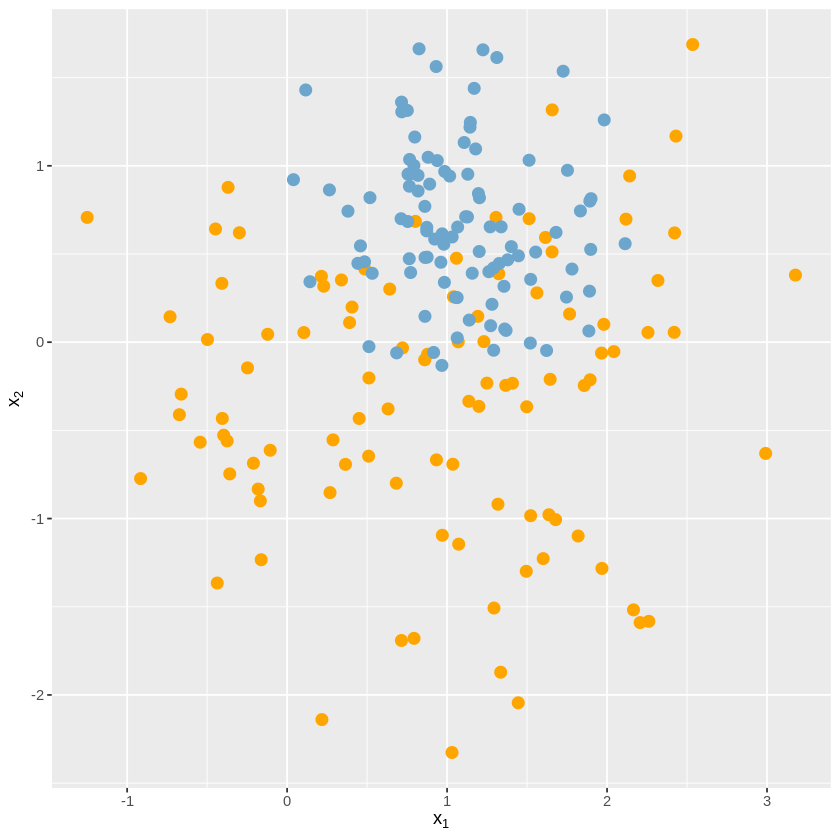

In [ ]:
ggplot(data = tabla) + 
geom_point(aes(x = X1, y = X2,col = factor(categoria) ), size = 3  )+
  xlab(expression(x[1])) + ylab(expression(x[2])) +
      scale_colour_manual(values = c("skyblue3", "orange")) +
      theme(legend.position = "none")

In [ ]:
#Modelo lineal
recta <-lm(categoria ~ X1 + X2, data = tabla)

B0 = recta$coefficients[1]
B1 = recta$coefficients[2]
B2 = recta$coefficients[3]

line=function(x){((0.5-B0)/B2)-((B1/B2)*x)}

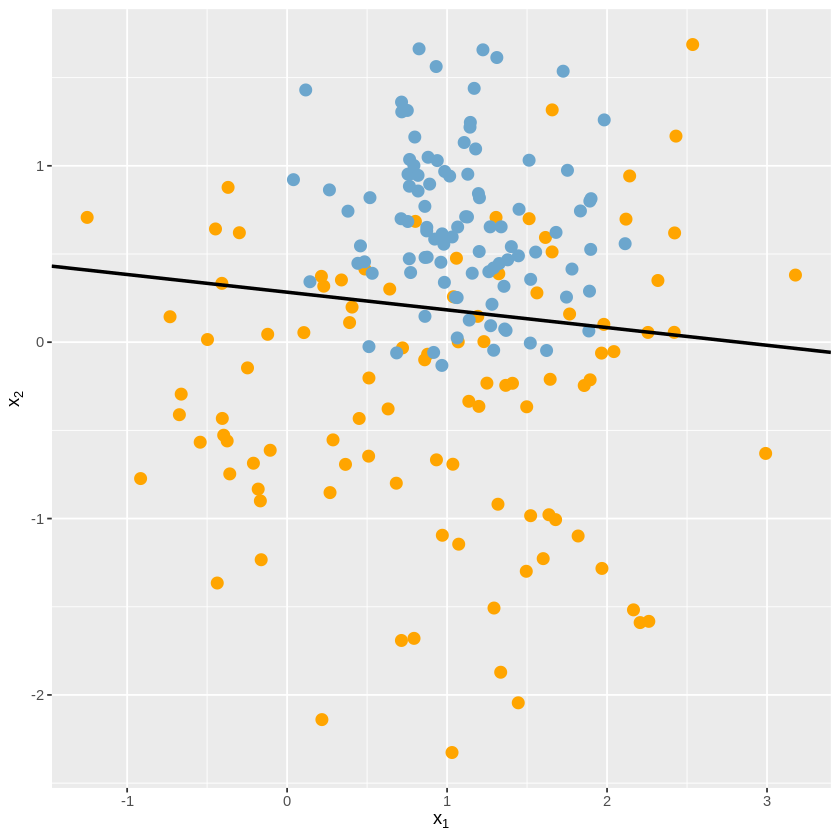

In [ ]:
g1 = ggplot(data = tabla) + 
geom_point(aes(x = X1, y = X2,col = factor(categoria) ), size = 3  )+
  xlab(expression(x[1])) + ylab(expression(x[2])) +
      scale_colour_manual(values = c("skyblue3", "orange")) +
      theme(legend.position = "none")
g2 = g1 + 
  geom_abline( intercept = (0.5-B0)/B2, slope = (-((B1/B2))), 
  size = 1, colour = 'black')+
  theme(legend.position = "none")
g2

In [ ]:
#convertimos las predicciones en 1 y 0
num2class <- function(pred, threshold=0.5) {
    ifelse(pred >= threshold, 1, 0)
}

In [ ]:
predicciones = predict(recta)

error_lineal_train = mean(num2class(predicciones) != tabla$categoria)
error_lineal_train

[1] 0.22

In [ ]:
# Definimos la grilla
paso_grilla = 0.05
rango_x <- extendrange(range(tabla$X1), f = 0.2)
rango_y <- extendrange(range(tabla$X2), f = 0.2)
grilla_x <- seq(rango_x[1], rango_x[2], paso_grilla)
grilla_y <- seq(rango_y[1], rango_y[2], paso_grilla)
grilla <- expand.grid(grilla_x, grilla_y)
colnames(grilla) <- c("X1", "X2")

# Predecimos la grilla
predicciones <- predict(recta, grilla)

# Convertimos la predicción continua a la clase asignada
grilla_pred <- cbind(grilla, clase = num2class(predicciones))

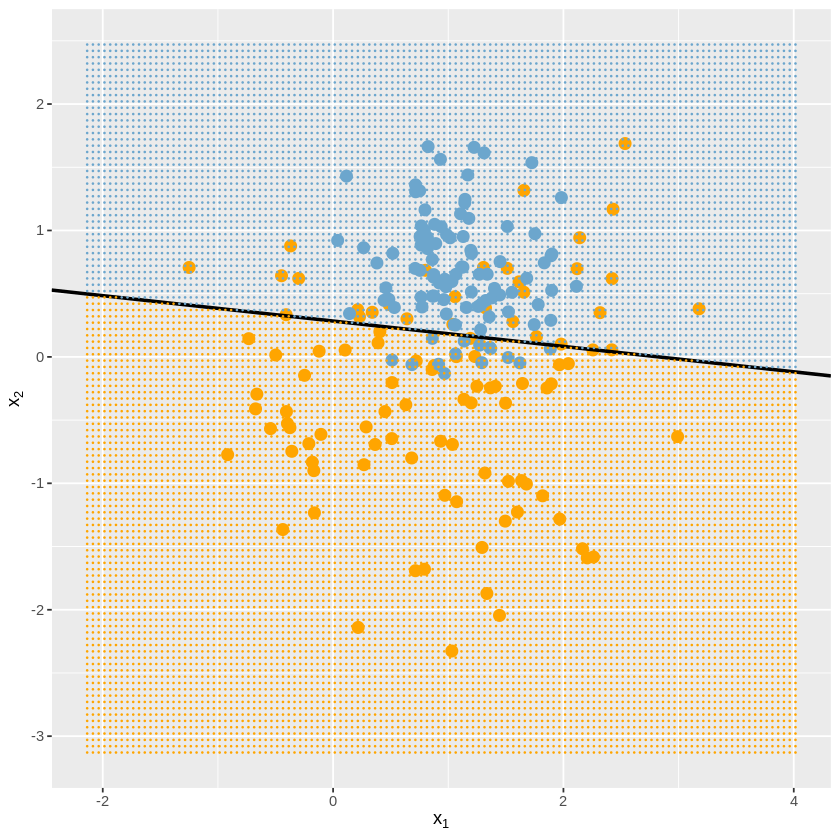

In [ ]:
# Gráfico con las regiones pintadas
g3 <- g2 +
    geom_point(data = grilla_pred,
               aes(x = X1, y = X2, colour = as.factor(clase)), size = 0.1)
g3

Vecinos cercanos:

knn(train, test, cl, k = 1, l = 0, prob = FALSE, use.all = TRUE)
k-nearest neighbour classification for test set from training set. For each row of the test set, the k nearest (in Euclidean distance) training set vectors are found, and the classification is decided by majority vote, with ties broken at random. If there are ties for the kth nearest vector, all candidates are included in the vote.

In [ ]:
# Ajustamos un modelo de 25 vecinos más cercanos
modelo_vecinos_25 <- knn(train = tabla[, -3],test = tabla[, -3], cl = tabla$categoria, 
                         k = 25)

In [ ]:
predicciones2 = (as.numeric(modelo_vecinos_25)-1)
error_25vecinos = mean(predicciones2 != tabla$categoria)
error_25vecinos

[1] 0.165

In [ ]:
# Ajustamos el modelo a una grilla para poder graficar:
modelo_vecinos_25 <- knn(train = tabla[, -3],test = grilla, cl = tabla$categoria, 
                         k = 25)

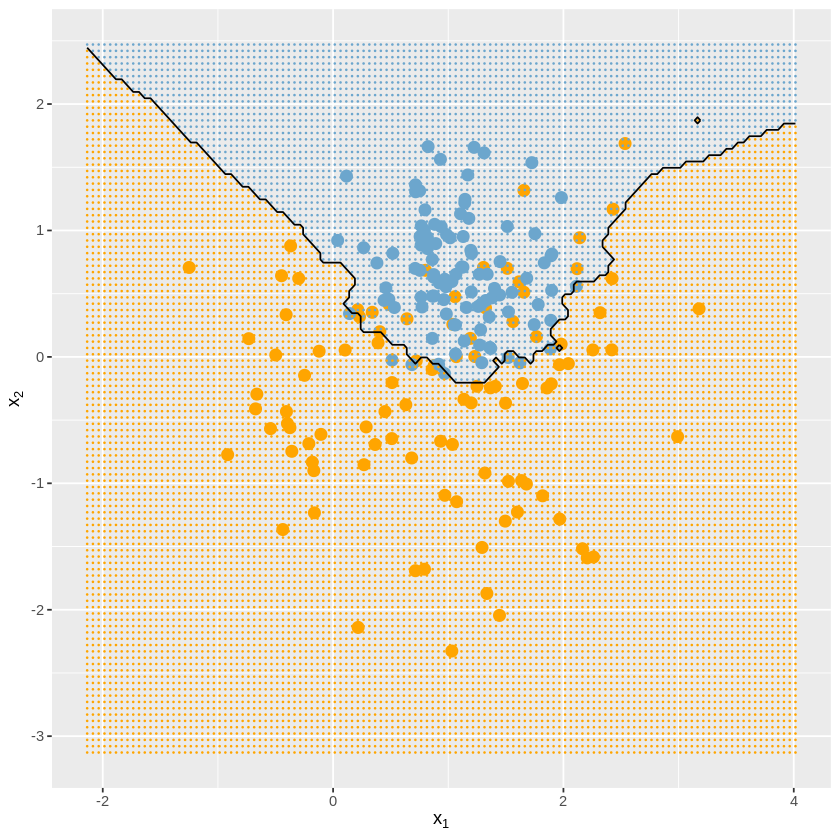

In [ ]:
grilla_pred_knn <- cbind(grilla, clase = as.numeric(modelo_vecinos_25)-1)

grilla_contour <- data.frame(x = grilla[, 1], y = grilla[, 2],
                             z = as.numeric(modelo_vecinos_25)-1)

g4 = g1 +
    geom_point(data = grilla_pred_knn,
               aes(x = X1, y = X2, colour = as.factor(clase)), size = 0.1) +
    geom_contour(data = grilla_contour,
                 aes(x = x, y = y, z = z), breaks = c(0, 0.5), col = "black") +
    theme(legend.position = "none")
g4

In [ ]:
# Ajustamos un modelo de 1 vecinos más cercanos
modelo_vecinos_1 <- knn(train = tabla[, -3],test = tabla[, -3], 
      cl = tabla$categoria,  k = 1)

In [ ]:
predicciones3 = (as.numeric(modelo_vecinos_1)-1)
error_1vecinos = mean(predicciones3 != tabla$categoria)
error_1vecinos

[1] 0

Con el momodelo de 1 vecin más cercano el error de predicción es cero.

In [ ]:
# Ajustamos el modelo de 1 vecinos más cercanos a la grilla
modelo_vecinos_1 <- knn(train = tabla[, -3],test = grilla, 
      cl = tabla$categoria,  k = 1)

grilla_pred_knn <- cbind(grilla, clase = as.numeric(modelo_vecinos_1)-1)

grilla_contour <- data.frame(x = grilla[, 1], y = grilla[, 2],
                             z = as.numeric(modelo_vecinos_1)-1)
                      

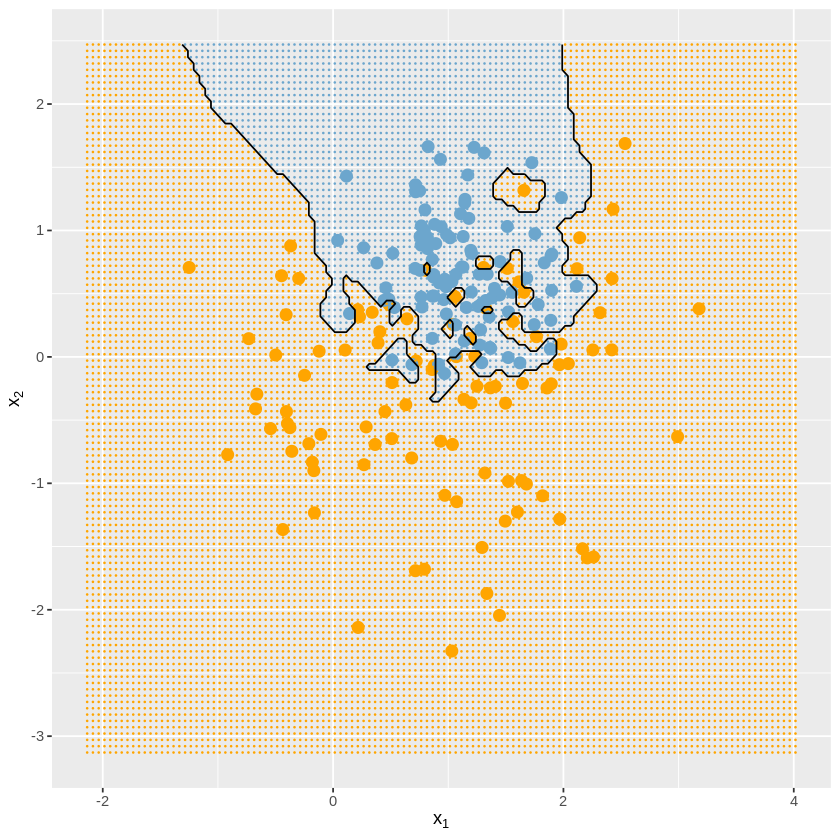

In [ ]:
g5 = g1 +
    geom_point(data = grilla_pred_knn,
               aes(x = X1, y = X2, colour = as.factor(clase)), size = 0.1) +
    geom_contour(data = grilla_contour, aes(x = x, y = y, z = z),
    breaks = c(0, 0.5), col = "black") +
    theme(legend.position = "none")
g5

Comparacion de k vecinos

In [ ]:
##Generamos nuevas observaciones para testear
tabla_test = medias(5000)

In [ ]:
##Calculamos errores de predicion para cada valor de k

train <- c()
test <- c()

for (i in seq(1,150, 3)){
pred_train <- knn(train = tabla[, -3],test = tabla[, -3] , 
      cl = tabla$categoria,  k = i)

pred_test <- knn(train = tabla[, -3],test = tabla_test[,-3], 
      cl = tabla$categoria,  k = i)

train = cbind ( train, mean((as.numeric(pred_train)-1) != tabla[, 3]))
test = cbind (test,  mean((as.numeric(pred_test)-1) != tabla_test[, 3]))
}

In [ ]:
length(pred_train)
length(pred_test)

[1] 200

[1] 10000

Graficamos el error de prediccion de KNN
- training = 200 obs
- test = 10000 obs

El nivel de flexibilidad del modelo viene dado por 1/K, siendo 1 = muy rigido y cuanto mas cerca de 0 menos rígido

In [ ]:
k = seq(1,150, 3)
xx = 1/k 

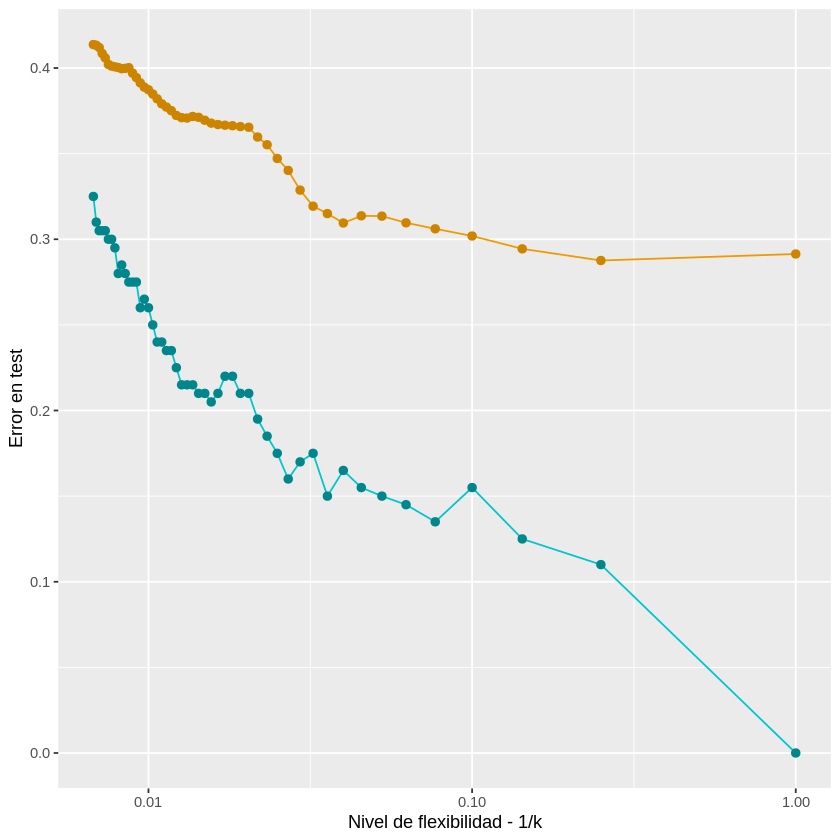

In [ ]:
dat = data.frame(train = t(train), test = t(test))
xx = 1/k  # nivel de flexibilidad
g6 = ggplot(dat) +
    geom_line(aes(x = xx, y = train), col = "turquoise3") +
    geom_point(aes(x = xx, y = train), size = 2, col = "turquoise4") +
    geom_line(aes(x = xx, y = test), colour = "orange2") +
    geom_point(aes(x = xx, y = test), colour = "orange3", size = 2) +
    ylab("Error en test") +
    xlab("Nivel de flexibilidad - 1/k") +
    scale_x_continuous(trans='log10') +
    theme(legend.position = "bottom", legend.justification = c("right", "top"))
g6

# Clase 2 - Validación cruzada

Para el conjunto de datos `Boston` del paquete `MASS`, considere la variable de respuesta `MEDV` y las covariables `LSTAT` y `RM`. Realice ajustes lineales considerando diferentes potencias para la covariable `LSTAT`. 
Elija aquel modelo que minimice el ECM mediante
* 5-fold cross-validation (partimos en 5 el dataset y, para cada bloque, entrenamos sin él y luego lo predecimos)
* leave-one-out (dejamos una observación afuera para entrenar y luego la predecimos)

In [ ]:
names(Boston)

[1] "crim"    "zn"      "indus"   "chas"    "nox"     "rm"      "age"    
 [8] "dis"     "rad"     "tax"     "ptratio" "black"   "lstat"   "medv"

In [ ]:
#Seleccionamos las variables a utilizar
K<-Boston %>% dplyr::select(lstat, medv, rm)

5-folds

In [ ]:
k1 = c(2:101)
k2 = c(102:201)
k3 = c(202:301)
k4 = c(302:401)
k5 = c(402:501)

In [ ]:
five_folds = function(grados){
 # Calculamos las regresiones para cada uno de los grupos, con diferentes
 #modelos para ver cuál ajusta mejor:
  r1 <- lm(medv ~ poly(lstat, grados) + rm, data = K[-k1,])
  r2 <- lm(medv ~ poly(lstat, grados) + rm, data = K[-k2,])
  r3 <- lm(medv ~ poly(lstat, grados) + rm, data = K[-k3,])
  r4 <- lm(medv ~ poly(lstat, grados) + rm, data = K[-k4,])
  r5 <- lm(medv ~ poly(lstat, grados) + rm, data = K[-k5,])

 # Calculamos el error de prediccion en cada grupo comparado con 
 # el grupo de testeo (error cuadrático medio):
  m1 = sqrt(mean((predict(r1, K[k1,])-K[k1,]$medv)^2))
  m2 = sqrt(mean((predict(r2, K[k2,])-K[k2,]$medv)^2))
  m3 = sqrt(mean((predict(r3, K[k3,])-K[k3,]$medv)^2))
  m4 = sqrt(mean((predict(r4, K[k4,])-K[k4,]$medv)^2))
  m5 = sqrt(mean((predict(r5, K[k5,])-K[k5,]$medv)^2))

  return(mean(m1,m2,m3,m4,m5))
}

In [ ]:
five_folds(1)
five_folds(2)
five_folds(3)
five_folds(4)
five_folds(5)
five_folds(6)
five_folds(7)


[1] 3.397533

[1] 3.501871

[1] 3.500211

[1] 3.388276

[1] 3.269197

[1] 3.36671

[1] 3.363285

El error de predicción es mínimo cuando usamos el modelo con polinomio de grado 5, a partir de esta conclusión podemos calcular el modelo general utilizando el polinomio de grado 5 y todos los valores de la muestra:

In [ ]:
modelo <- lm(medv ~ poly(lstat, 5) + rm, data = K)
modelo$coefficients

(Intercept) poly(lstat, 5)1 poly(lstat, 5)2 poly(lstat, 5)3 poly(lstat, 5)4 
      -1.587119     -115.263818       54.574953      -10.015939       20.229044 
poly(lstat, 5)5              rm 
     -21.718110        3.837920

Leave one out

In [ ]:
fit_mse <- function(modelo, df_folds, n) {
  train <- do.call(rbind, df_folds[-n])
  test <- df_folds[[n]]
  linear_fit <- lm(data=train, formula = modelo)
  pred <- predict(linear_fit, newdata = subset(test, select=-medv))
  rmse <- sqrt(mean((pred - test$medv)^2))
  mae <- median(abs((pred - test$medv)))
  return(rmse)
  }

In [ ]:
cv_error = function(modelo, df, k_folds) {
  idx_folds <- cut(seq(nrow(df)), breaks = k_folds, labels = FALSE)
  df_folds <- split(df, sample(idx_folds))
  errores <- sapply(1:k_folds, fit_mse, modelo = modelo, df_folds = df_folds)
  return(errores)
}

In [ ]:
eval_model <- function(k, df, k_folds) {
  modelo <- formula(paste("medv ~ poly(lstat,",k, ") + rm"))
  errores <- cv_error(modelo, df, k_folds)
  return(errores)
}

In [ ]:
##Cross validation
k_folds <- nrow(K)
grados <- 1:7
errorescv = sapply(grados, eval_model, df = K, k_folds = k_folds)

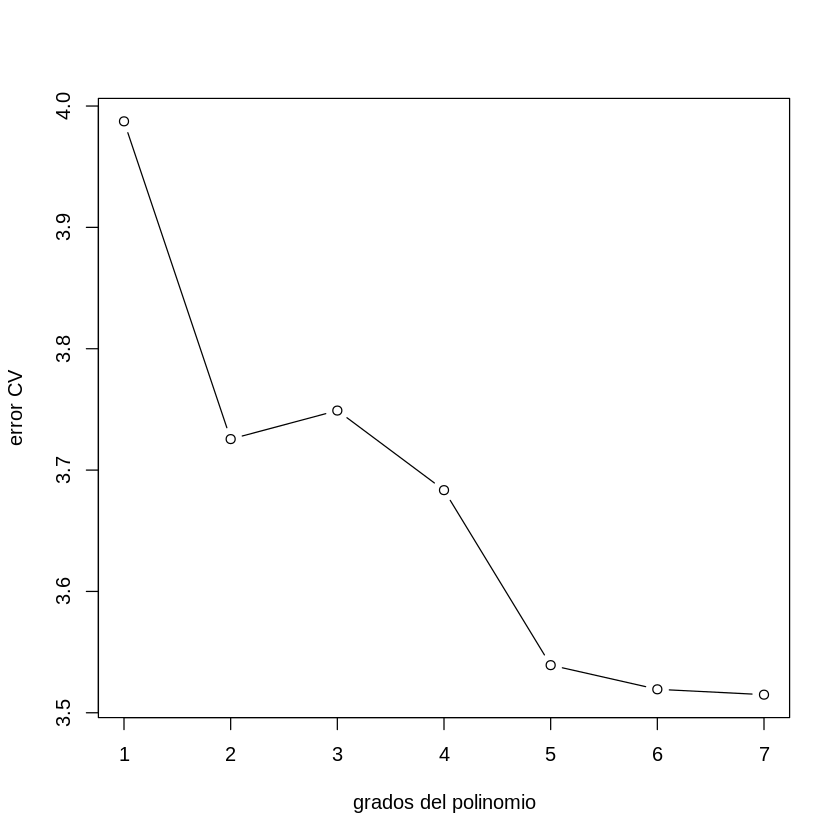

In [ ]:
plot (grados, apply(errorescv, 2, mean), ylab = 'error CV', xlab = 'grados del polinomio', type = 'b')

Con el método de Cross-Validation podemos comparar diferentes modelos y determinar cuál ajusta mejor a los datos que queremos predecir, en este caso podemos ver que a medida que aumentan los grados del polinomio el error de predicción disminuye, sin embargo si la disminucion en el error no es muy significativa conviene elegir un modelo más simple, es decir con menos grados en el polinomio. En este sentido conviene elegir quizás un modelo con polinomio de grado 5 con el método de leave-one-out porque la disminución que vemos luego es muy pequeña y de esta maner vemos que coincide con la conclusión hallada a través del método de 5-folds.

# Clase 4a - Método de momentos y estimador de máxima verosimilitud (Poisson)

Dada una distribución de Poisson de parámetro $\lambda$, defina una función que compute el estimador basado en el primer momento y otra para el estimador basado en el segundo momento. 
1. Pruebe que ambos estimadores son consistentes para $\lambda$.
2. Genere 10000 muestras y compare los histogramas de las estimaciones por ambos métodos. ¿Qué pasa con el sesgo y la varianza? Calcule (o simule) el sesgo.
3. Generar una muestra de tamaño 30 y graficar las funciones de verosilimitud y log-verosimilitud para la muestra obtenida. Corrobore que el máximo se alcanza en la estimación de máxima verosimilitud. 


In [ ]:
##primer momento:
estimador1 = function(x) {
  return(mean(x))
  }

##segundo momento:
estimador2 = function(x){
  return( sqrt(1/4+(mean(x^2)))-1/2 )
}

Generar 10000 muestras y comparar los histogramas de las estimaciones por ambos métodos.

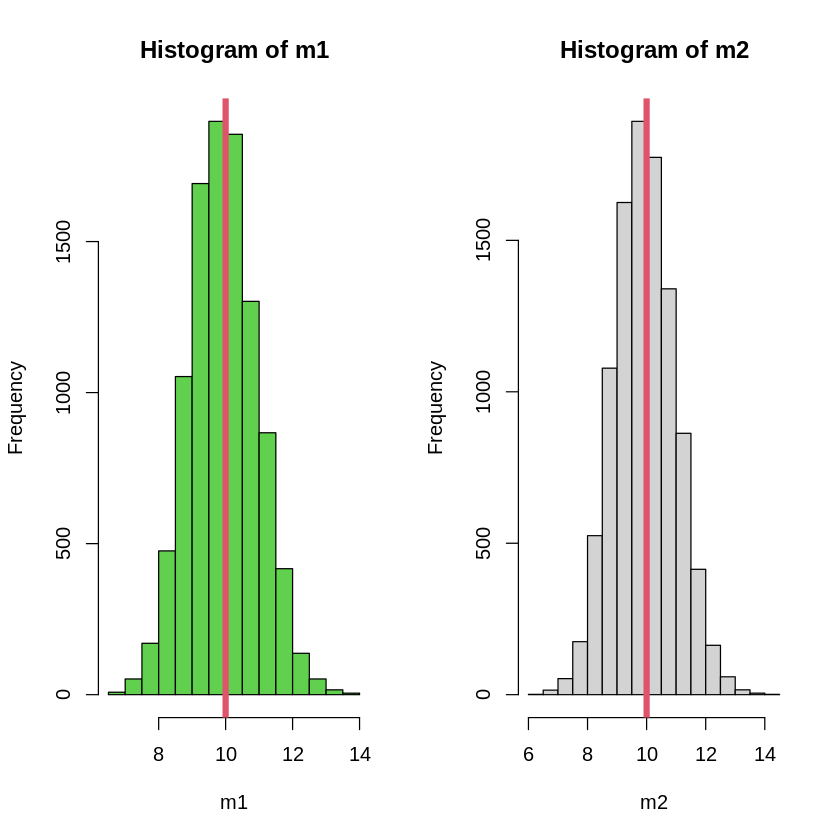

In [ ]:
lambda = 10
m1 <- c()
m2 <- c()

for (i in 1:10000){
  x <- rpois(10, lambda)
  m1 <- append(m1, estimador1(x))
  m2 <- append(m2, estimador2(x))
}

par(mfrow = c(1, 2))
ggp1 = hist(m1, col = 3)
abline(v = lambda, col = 2, lwd = 5)


ggp2 = hist(m2)
abline(v = lambda, col = 2, lwd = 5)

##elegimos el que tiene menor varianza

In [ ]:
#Simulamos el sesgo
abs(mean(m1)-lambda)
abs(mean(m2)-lambda)

#Simulamos la varianza
var(m1)
var(m2)

##el estimador del primero momento tiene un sesgo y una varianza un poco menor

[1] 0.01772

[1] 0.06742803

[1] 1.005571

[1] 1.049007

Convergencia en probabilidad de los estimadores

In [ ]:
lambda = 10

conv1 = c()
conv2 = c()
for (n in 1:1000){
  x <- rpois(n, lambda)
  m1 <- c()
  m2 <- c()
    for (i in 1:1000){

      m1 <- append(m1, estimador1(x))
      m2 <- append(m2, estimador2(x))
    }
  conv1 = append(conv1, mean(m1))
  conv2 = append(conv2, mean(m2))
}

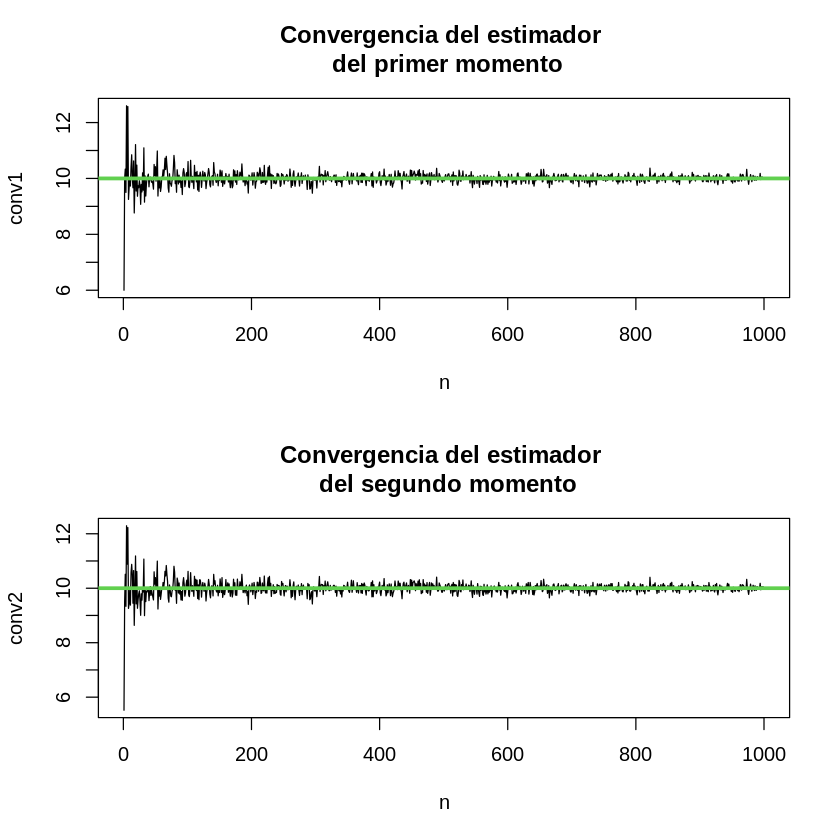

In [ ]:
n = seq(1:1000)
par(mfrow = c(2,1))
plot(n,conv1, type = 'l', main = 'Convergencia del estimador \n del primer momento')
abline(h=10, col = 3, lwd = 3)
plot(n,conv2, type = 'l', main = 'Convergencia del estimador \n del segundo momento')
abline(h=10, col = 3, lwd = 3)
#A medida que aumenta n el sesgo se vuelve mas pequeño

Verosimilitud y Log-verosimilitud

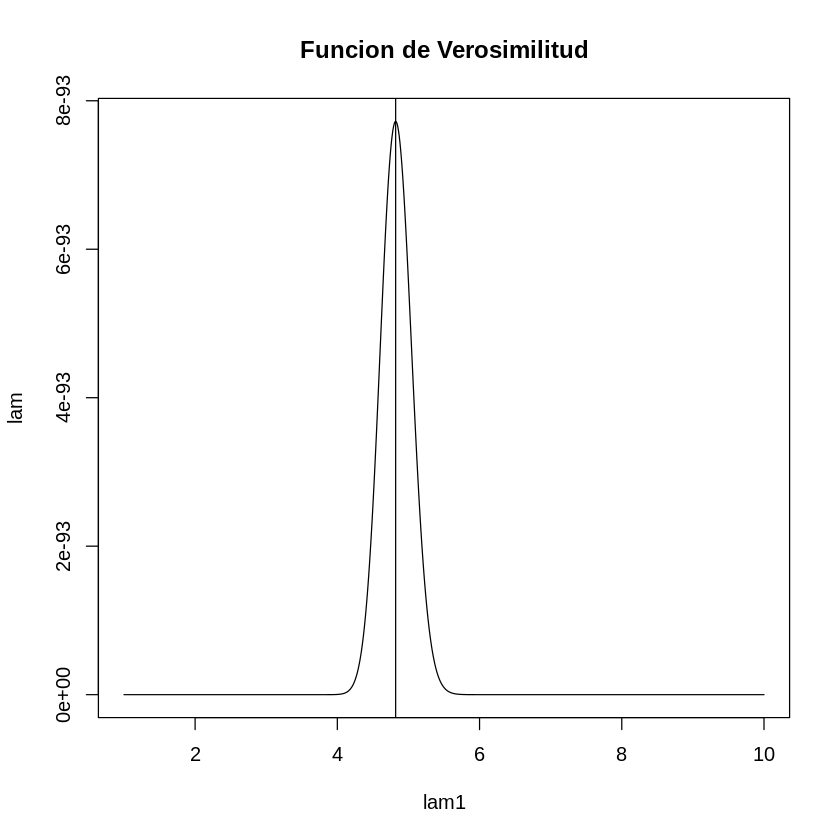

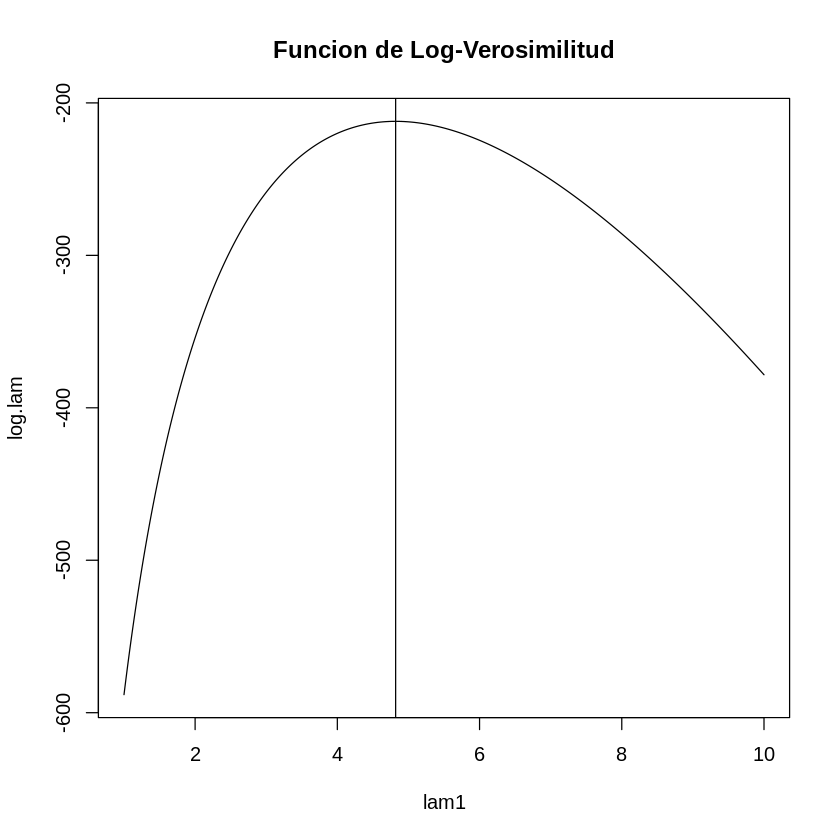

In [ ]:
n = 100
lambda=5
x <- rpois(n, lambda)

densidad = function(lambda){ return ( (exp(-lambda)*lambda^x)/factorial(x) ) }
verosim = function(j){ return (prod(densidad(j))) }

log.verosim = function(lambda){ return ( -n*lambda - sum(log(factorial(x))) + log(lambda)*sum(x)    ) }


lam = c()
log.lam=c()
for (i in seq(1, 10,0.01 )){
  densidad = function(lambda){ return ( (exp(-lambda)*lambda^x)/factorial(x) ) }
  verosim = function(j){ return (prod(densidad(j))) }
  
  log.verosim = function(lambda){ return ( -n*lambda - sum(log(factorial(x))) + log(lambda)*sum(x)    ) }
  
  
  lam = append( lam, verosim(i))  
  log.lam= append( log.lam, log.verosim(i))
  }

ll = optimise(verosim, c(1,10), maximum = T)
#El valor máximo de la función es muy cercano a 0, si aumentamos el valor de n
# la maximizacion no funciona.

lll = optimize(log.verosim, c(1,10), maximum = T)

lam1= seq(1,10, 0.01)
plot(lam1, lam, type = 'l', main = 'Funcion de Verosimilitud')
abline(v = ll$maximum)

plot(lam1, log.lam, type = 'l', main = 'Funcion de Log-Verosimilitud')
abline(v = lll$maximum)

# Clase 4b - Método de momentos y estimador de máxima verosimilitud (Gamma)

Dada una variable aleatoria $\Gamma(\alpha,\lambda)$
$$f(x;\alpha,\lambda) = \frac{1}{\Gamma(\alpha)} \lambda^{\alpha} x^{\alpha-1}
      e^{-\lambda x}, \quad 0 \leq x < \infty$$
1. Calcule analíticamente el estimador de momentos para el parámetro $(\alpha,\lambda)$.
2. Halle las ecuaciones que dan lugar al estimador de máxima verosimilitud para $(\alpha,\lambda)$.
3. Estime por ambos métodos los parámetros para el dataset **gamma-arrivals.csv**. Grafique el histograma de la muestra y las densidades estimadas.
    
Sugerencias:
* use la función **nlm** u **optim** para la minimización numérica
* en el comando **rgamma**, $\alpha$ corresponde al parámetro _shape_ y $\lambda$ a _scale_.



$$ X \sim Gamma( \alpha , \lambda)$$
$$  momento 1 \begin{cases} \begin{array}{c} \begin{align} & \mu_{1} =E(x)=\frac{\alpha}{\lambda}  \\ & \hat{\mu_{1}} = \frac{1}{n}\sum_{i = 1}^{n} x_{i} = \overline{x} \end{align} \end{array} \end{cases} $$
$$ momento2 \begin{cases} \begin{array}{c} \begin{align} & \mu_{2} =E(x^2)=V(x)+E(x)^2 = \frac{\alpha}{\lambda^2} +\frac{\alpha^2}{\lambda^2} = \frac{\alpha(\alpha + 1)}{\lambda^2} \\ & \hat{\mu_{2}} = \frac{1}{n}\sum_{i = 1}^{n} x_{i}^2 = \overline{x^2} \end{align} \end{array} \end{cases} $$


$$ \begin{cases} \begin{array}{c} \begin{align} & 1 : \frac{1}{n}\sum_{i = 1}^{n} x_{i}=\frac{\alpha}{\lambda}  \\ & 2 : \frac{1}{n}\sum_{i = 1}^{n} x_{i}^2 = \frac{\alpha(\alpha + 1)}{\lambda^2} \end{align} \end{array} \end{cases} $$

De la primera ecuación tenemos que:

$$ \alpha = \lambda \overline{x} $$
Reemplazamos en la segunda ecuación:
$$ \frac{ \lambda \overline{x}(\lambda \overline{x}+1)}{\lambda^2}= \overline{x^2} $$
$$ \lambda( \overline{x}^2-\overline{x^2})= -\overline{x} $$
Despejamos los estimadores de momentos:
$$\begin{cases} \begin{array}{c} \begin{align} & \hat{\lambda}_{MM}=\frac{\overline{x}}{Var(x)} \\ & \hat{\alpha}_{MM} = \hat{\lambda} \overline{x}=\frac{ \overline{x}^2}{Var(x)}  \end{align} \end{array} \end{cases}$$

In [ ]:
##Estimadores de momentos
lambda_mm = function(x) {
  m = mean(x)
  v = var(x)
  return(m/v)
  }

alpha_mm = function(x){
  m = mean(x)
  v = var(x)
  return((m^2)/v )
}

In [ ]:
alfa <- 1
lambda <- 0.01
x <- rgamma(10000, alfa, lambda)
lambda_mm(x)
alpha_mm(x)


[1] 0.009846515

[1] 0.9892871

Estimadores de Váxima Verosimilitud:
$$ L(\alpha,\lambda)= \frac{1}{\Gamma(\alpha)^n}(\prod_{i=1}^{n}x_{i})^{\alpha-1}\lambda^{n\alpha}e^{-\alpha n \overline{x_{n}}} $$
$$ l (\alpha,\lambda)=  -n \log(\Gamma(\alpha))+(\alpha -1)\sum_{i=1}^{n}\log (x_{i})+n \alpha \log(\lambda)-\lambda n \overline{x_{n}}  $$
Calculamos las derivadas arciales de la función $l (\alpha,\lambda)$ e igualamos a 0:

$$(1) \frac{\delta l}{\delta \alpha}(\alpha,\lambda)=\frac{-n}{\Gamma(\alpha)}\Gamma '(\alpha) + \sum logx_{i} + n log(\lambda) = 0$$

$$(2) \frac{\delta l}{\delta \lambda}(\alpha,\lambda) = \frac{n\alpha}{\lambda} - n\overline{x_{n}} = 0$$

De la ecuación 2 podemos despejar el valor de $\alpha$:

$$ \alpha = \overline{x_{n}}\lambda $$

Sin embargo despejar el valor de $\lambda$ no nos da un resultado concreto, por lo tanto utilizamos el comando nlm para maximizar la funcion de log verosimilitud, que es lo mismo que minimizar:
$$-l (\alpha,\lambda)$$

In [ ]:
minus_loglik_gamma <- function(param,data){
  alpha <- param[1]
  lambda <- param[2]
  n_obs <- length(data)
  sum_data <- sum(data)
  sum_log_data <- sum(log(data))

  ret_1 <- n_obs*alpha*log(lambda)
  ret_2 <- -n_obs*lgamma(alpha)
  ret_3 <- -lambda*sum_data
  ret_4 <- (alpha-1)*sum_log_data

  ret <- ret_1 + ret_2 + ret_3 + ret_4

  return(-ret)
}

In [ ]:
datos <- scan('gamma-arrivals.csv')

In [ ]:
alpha_mm(datos)
lambda_mm(datos)

[1] 1.012095

[1] 0.01266144

In [ ]:
mom_gamma <- c(alpha_mm(datos), lambda_mm(datos))

mle_fit <- nlm(f=minus_loglik_gamma, p=mom_gamma, hessian=FALSE, data=datos)

mle_gamma <- mle_fit$estimate
mle_gamma

Warning message in log(lambda):
“NaNs produced”
Warning message in nlm(f = minus_loglik_gamma, p = mom_gamma, hessian = FALSE, data = datos):
“NA/Inf replaced by maximum positive value”
Warning message in log(lambda):
“NaNs produced”
Warning message in nlm(f = minus_loglik_gamma, p = mom_gamma, hessian = FALSE, data = datos):
“NA/Inf replaced by maximum positive value”
Warning message in log(lambda):
“NaNs produced”
Warning message in nlm(f = minus_loglik_gamma, p = mom_gamma, hessian = FALSE, data = datos):
“NA/Inf replaced by maximum positive value”


[1] 1.02636176 0.01284018

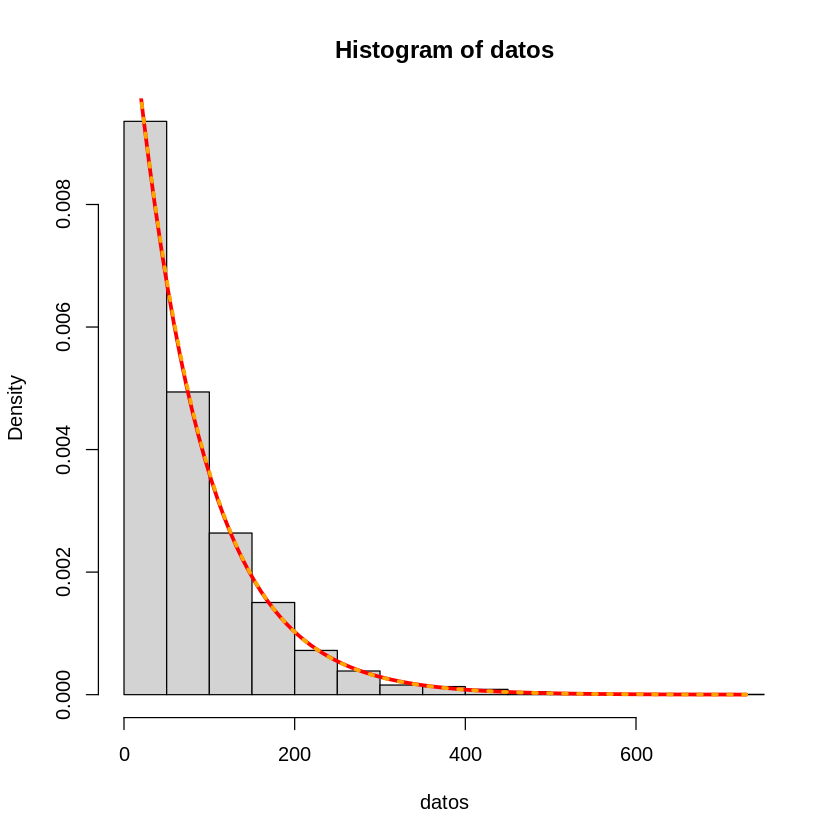

In [ ]:
hist(datos, freq = F)
curve(dgamma(x, shape = mom_gamma[1], rate = mom_gamma[2]),
   min(datos), max(datos), add = TRUE , col = 'red' , lwd = 3 )
curve(dgamma(x, shape = mle_gamma[1], rate = mle_gamma[2]),
   min(datos), max(datos), add = TRUE , col = 'orange' , lwd = 3, lty=3 )

Ambas curvas coinciden, tanto la calculada por el método de momentos como la calculada con la funcion de máxima verosimilitud.

# Clase 5 - Sesgo y varianza (german tank problem)

Dada una distribución uniforme discreta en $\{1, \dots, N\}$, queremos estimar el tamaño $N$ de la población. Considere los estimadores:
* de máxima verosimilitud $\widehat{N}_{EMV} =\max_{1\leq i \leq N} (x_i)$,
* el estimador insesgado construido a partir del EMV,
* $2\overline{X}_N-1$,
* $\max_{1\leq i \leq N} (x_i)-\min_{1\leq i \leq N}(x_i)-1$.

Mediante simulación, compare sus sesgos y varianzas. Ilustre con boxplots e histogramas para cada estimador.

In [ ]:
emv <- function(x){
  return(max(x))
}

est_insesg <- function(x,n){
  return((max(x)*((n+1)/n))-1)
}

est_3 <- function(x){
  return(2*mean(x)-1)
}

est_4 <- function(x){
  return(max(x)+min(x)-1)
}

In [ ]:
nrep <- 1e4
n_grande <- 300
n <- 5

test_emv <- c()
test_estins <- c()
test_est3 <- c()
test_est4 <- c()

for (i in 1:nrep){
  x <- sample(1:n_grande,n,replace=FALSE)
  
  a <- emv(x)
  b <- est_insesg(x,n)
  c <- est_3(x)
  d <- est_4(x)

  test_emv <- append(test_emv, a)
  test_estins <- append(test_estins, b)
  test_est3 <- append(test_est3, c)
  test_est4 <- append(test_est4, d)
}

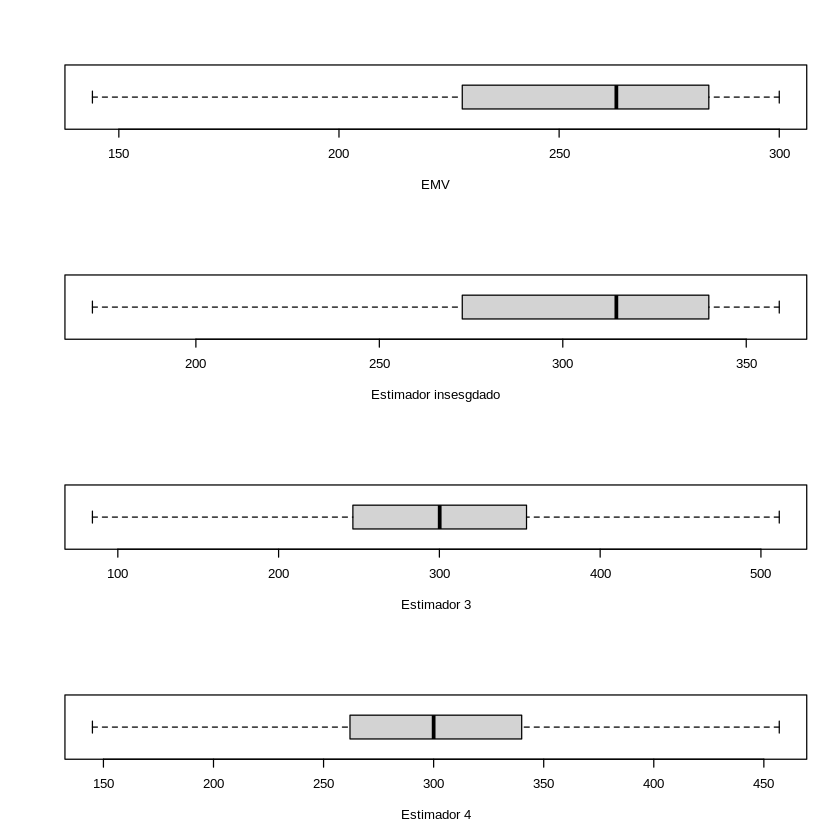

In [ ]:
par(mfrow = c(4, 1))

boxplot(test_emv, horizontal = TRUE, outline=FALSE, xlab = 'EMV')
boxplot(test_estins, horizontal = TRUE, outline=FALSE, xlab = 'Estimador insesgdado')
boxplot(test_est3, horizontal = TRUE, outline=FALSE, xlab = 'Estimador 3')
boxplot(test_est4, horizontal = TRUE, outline=FALSE, xlab = 'Estimador 4')

# Clase 7a - Intervalos de confianza

1. Programe el intervalo de confianza para la media basado en la
 * distribución normal (asintótico),
 * distribucion t.

2. Evalue la cobertura empírica (cuántas veces contiene al parámetro verdadero) para familias
  * normal,
  * t (colas más pesadas),
  * exponencial (asimétrica).

¿Si aumentamos el tamaño de muestra mejora la cobertura?

In [ ]:
##Intervalo de confiaza asintótico

IC_norm = function(x, alfa){
  n = length(x)
  media = mean(x)
  sigma = sqrt(var(x))
  z = qnorm (1 - alfa/2)
  linf = media - z * sigma / sqrt ( n )
  lsup = media + z * sigma / sqrt ( n )
  return(c(linf,lsup))
}

##Intervalo de confianza t-student

IC_ts = function(x, alfa){
  n = length(x)
  media = mean(x)
  s = sd(x)
  t = qt (1 - alfa/2, n-1)
  linf = media - t * s / sqrt ( n )
  lsup  = media + t * s / sqrt ( n )
  return(c(linf,lsup))
}


Evaluamos la cobertura

La estimación por intervalo de confianza de μ , cuando σ es
desconocido, pero la muestra es suficientemente grande, podemos hacer una aproximación asintótica gracias al TCL y al teorema de Slutsky y utilizar una distibución normal para su cálculo.

In [ ]:
# Definimos los parametros
nreps = 1000
mu = 5
n = 100
sigma = 10
alfa = 0.1


# Calculamos los IC
linf = lsup = numeric ( nreps )
for ( iter in 1: nreps ){
muestra = rnorm (n , mu , sigma )
linf [ iter ] = IC_norm(muestra, alfa)[1]
lsup [ iter ] = IC_norm(muestra, alfa)[2]
}

# Proporcion que el IC contiene al mu verdadero
mean (( mu < lsup ) * ( mu > linf ))

[1] 0.902

La estimación por intervalo de confianza de μ , cuando σ es
desconocido, se distribuye t con n-1 gl.

In [ ]:
# Definimos los parametros
nreps = 1000
mu = 0
n = 10
sigma = 10
alfa = 0.1


# Calculamos los IC
linf = lsup = numeric ( nreps )
for ( iter in 1: nreps ){
muestra = rnorm (n , mu , sigma )
linf [ iter ] = IC_ts(muestra, alfa)[1]
lsup [ iter ] = IC_ts(muestra, alfa)[2]
}

# Proporcion que el IC contiene al mu verdadero
mean (( mu < lsup ) * ( mu > linf ))

[1] 0.893

Variable exponencial

In [ ]:
# Definimos los parametros
nreps = 1000
rate = 3
mu = 1/rate
n = 100
alfa = 0.1


# Calculamos los IC
linf = lsup = numeric ( nreps )
for ( iter in 1: nreps ){
muestra = rexp (n , rate )
linf [ iter ] = IC_norm(muestra, alfa)[1]
lsup [ iter ] = IC_norm(muestra, alfa)[2]
}

# Proporcion que el IC contiene al mu verdadero
mean (( mu < lsup ) * ( mu > linf ))

[1] 0.862

El tamaño de muestra no mejora la cobertura, pero al aumentar n el intervalo será más pequeño ya que disminuye la varianza del estimador.

# Clase 7b - Intervalos de confianza

1. Calcule un intervalo de confianza de nivel aproximado 95% para los estimadores de máxima verosimilitud obtenidos para el conjunto de datos `gamma-arrivals.csv`.

2. Estudie la cobertura del intervalo de confianza asintótico para el estimador de máxima verosimilitud mediante la simulación de una distribución gamma de parámetros conocidos.

In [ ]:
datos <- scan('gamma-arrivals.csv')

mom_gamma <- c(alpha_mm(datos), lambda_mm(datos))

mle_fit <- nlm(f=minus_loglik_gamma, p=mom_gamma, hessian=TRUE, data=datos)

mle_gamma <- mle_fit$estimate
I_mv = mle_fit$hessian

Warning message in log(lambda):
“NaNs produced”
Warning message in nlm(f = minus_loglik_gamma, p = mom_gamma, hessian = TRUE, data = datos):
“NA/Inf replaced by maximum positive value”
Warning message in log(lambda):
“NaNs produced”
Warning message in nlm(f = minus_loglik_gamma, p = mom_gamma, hessian = TRUE, data = datos):
“NA/Inf replaced by maximum positive value”
Warning message in log(lambda):
“NaNs produced”
Warning message in nlm(f = minus_loglik_gamma, p = mom_gamma, hessian = TRUE, data = datos):
“NA/Inf replaced by maximum positive value”


In [ ]:
##Inverse Fisher information gives the asymptotic variance matrix of the MLE.
inv.fish = solve(I_mv)

In [ ]:
inv.fish

4.223940e-04,5.345991e-06
5.345991e-06,1.091204e-07


In [ ]:
##Intervalo de confiaza basado en MV

IC_alfa_mv = function(param, inv.fish, alfa){
  n = length(x)
  alfa1 = param[1]
  sigma = sqrt(inv.fish[1,1])
  z = qnorm (1 - alfa/2)
  linf = alfa1 - z * sigma
  lsup = alfa1 + z * sigma
  return(c(linf,lsup))
}

IC_lambda_mv = function(param, inv.fish, alfa){
  n = length(x)
  lambda = param[2]
  sigma = sqrt(inv.fish[2,2])
  z = qnorm (1 - alfa/2)
  linf = lambda - z * sigma
  lsup = lambda + z * sigma
  return(c(linf,lsup))
}

Calculamos los intervalos de confianza de 95% para los parámetros de MV

In [ ]:
IC_alfa_mv(mle_gamma, inv.fish, 0.05)
IC_lambda_mv(mle_gamma, inv.fish, 0.05)

[1] 0.9860801 1.0666434

[1] 0.01219274 0.01348763

Cobertura del intervalo de confianza

In [ ]:
n = 100
shape = 2
rate = 1

nreps = 100

# Calculamos los IC
linf = lsup = numeric ( nreps )
for ( iter in 1: nreps ){
  x = rgamma(n, shape, rate)
  mom_gamma <- c(alpha_mm(x), lambda_mm(x))

  mle_fit <- nlm(f=minus_loglik_gamma, p=mom_gamma, hessian=TRUE, data=x)

  mle_gamma <- mle_fit$estimate
  I_mv = mle_fit$hessian
  inv.fish = solve(I_mv)
  linf [ iter ] = IC_alfa_mv(mle_gamma, inv.fish, 0.05)[1]
  lsup [ iter ] = IC_alfa_mv(mle_gamma, inv.fish, 0.05)[2]
}

# Proporcion que el IC contiene al alfa verdadero
mean (( shape < lsup ) * ( shape > linf ))

[1] 0.95

In [ ]:
n = 100
shape = 2
rate = 1

nreps = 100

# Calculamos los IC
linf = lsup = numeric ( nreps )
for ( iter in 1: nreps ){
  x = rgamma(n, shape, rate)
  mom_gamma <- c(alpha_mm(x), lambda_mm(x))

  mle_fit <- nlm(f=minus_loglik_gamma, p=mom_gamma, hessian=TRUE, data=x)

  mle_gamma <- mle_fit$estimate
  I_mv = mle_fit$hessian
  inv.fish = solve(I_mv)
  linf [ iter ] = IC_lambda_mv(mle_gamma, inv.fish, 0.05)[1]
  lsup [ iter ] = IC_lambda_mv(mle_gamma, inv.fish, 0.05)[2]
}

# Proporcion que el IC contiene al lambda verdadero
mean (( rate < lsup ) * ( rate > linf ))

[1] 0.94

# Clase 8 - Bootstrap

1. Para los estimadores de momentos y máxima verosimilitud obtenidos para el conjunto de datos `gamma-arrivals.csv`:
  * estime mediante boostrap su error estándar y 
  * calcule un IC de nivel aproximado 95%.
2. Para el estimador de máxima verosimilitud calcule un IC de nivel aproximadamente 95% basado en la distribución asintótica.

Además de hacer bootstrap manualmente, pueden comparar con lo obtenido por el paquete `boot`.

3. Para una distribución cuya mediana sepa calcular, mediante simulación, aproxime la distribución de la mediana muestral. Genere una muestra y compare la distribución bootstrap con la distribución muestral estimada por simulación.

In [ ]:
datos <- scan('gamma-arrivals.csv')

In [ ]:
# Estimador de momentos para la gamma
momentos_gamma <- function(data) {
    n <- length(data)
    mu <- mean(data)
    sigma2 <- var(data)*(n-1)/n
    return(c(mu^2 / sigma2, mu / sigma2))
}

In [ ]:
mom_gamma <- momentos_gamma(datos) #Estimadores de la muestra original
mom_gamma
#Realizamos 10000 muestras con repeticion y calculamos los estimadores de c/u
boots = replicate(1e4, momentos_gamma(sample(datos, replace = TRUE)))

[1] 1.01235221 0.01266466

Intervalos de confianza

In [ ]:
alpha_m_b = sort(boots[1,], decreasing = FALSE)
lambda_m_b = sort(boots[2,], decreasing = FALSE)

In [ ]:
#calculamos los desvios estandar de las distribuciones
ds_alpha = sd(alpha_m_b)
ds_lambda = sd(lambda_m_b)
ds_alpha
ds_lambda

[1] 0.03214094

[1] 0.0004492442

In [ ]:
n = length(datos)
t = qt ((1-0.05/2) , n-1) #Utilizamos la distribución t
lim_sup = mom_gamma[1] + ( ds_alpha  * t)
lim_inf = mom_gamma[1] - ( ds_alpha * t)
IC_alpha_mom = c(lim_inf, lim_sup)
IC_alpha_mom

n = length(datos)
t = qt ((1-0.05/2) , n-1) #Utilizamos la distribución t
lim_sup = mom_gamma[2] + ( ds_lambda  * t)
lim_inf = mom_gamma[2] - ( ds_lambda * t)
IC_lambda_mom = c(lim_inf, lim_sup)
IC_lambda_mom

[1] 0.9493377 1.0753667

[1] 0.01178388 0.01354543

Para construir el intervalo de confianza asintótico necesitamos saber cómo varı́a la
distribución de X alrededor de μ. 

Queremos conocer la distribución de
$$ \varDelta = \overline{X_{n}}- \mu $$

In [ ]:
#calculamos la variación del estimador
delta_alpha = alpha_m_b - mom_gamma[1] 
delta_lambda = lambda_m_b - mom_gamma[2] 

In [ ]:
#Calculamos los cuantiles de la distibución
dist_alpha = quantile(delta_alpha, c(0.975, 0.025))
dist_lambda = quantile(delta_lambda, c(0.975, 0.025))

A partir de la distribución asintótica del estimador podemos armar los intervalos de confianza del 95%

In [ ]:
lim_sup_a = mom_gamma[1] + ( dist_alpha[1][[1]])
lim_inf_a = mom_gamma[1] +  (  dist_alpha[2][[1]]) 
IC_alpha_mom_a = c(lim_inf_a, lim_sup_a)
IC_alpha_mom_a

lim_sup_a = mom_gamma[2] + ( dist_lambda[1][[1]])
lim_inf_a = mom_gamma[2] +  (  dist_lambda[2][[1]]) 
IC_lambda_mom_a = c(lim_inf_a, lim_sup_a)
IC_lambda_mom_a

[1] 0.9513376 1.0780290

[1] 0.01183290 0.01359259

El inervalo de confianza para alfa y lambda está corrido hacia la derecha con la distribución asintótica, en comparación con la distribución t-student, esto indica que la distribución asintotica no es simétrica, ya que ambos intervalos están centrados en el mismo valor.

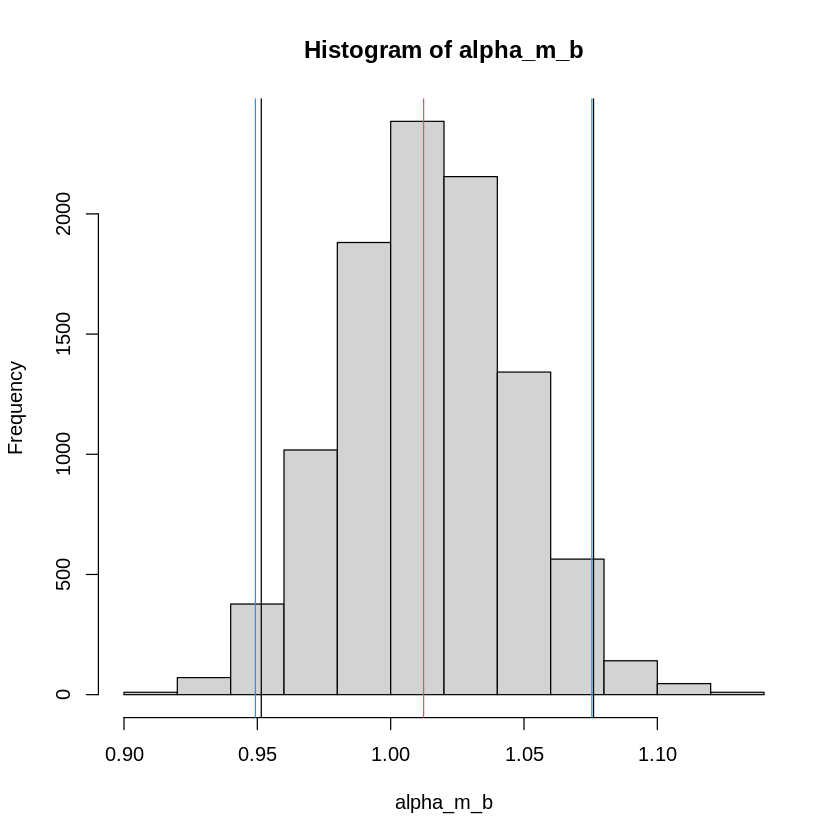

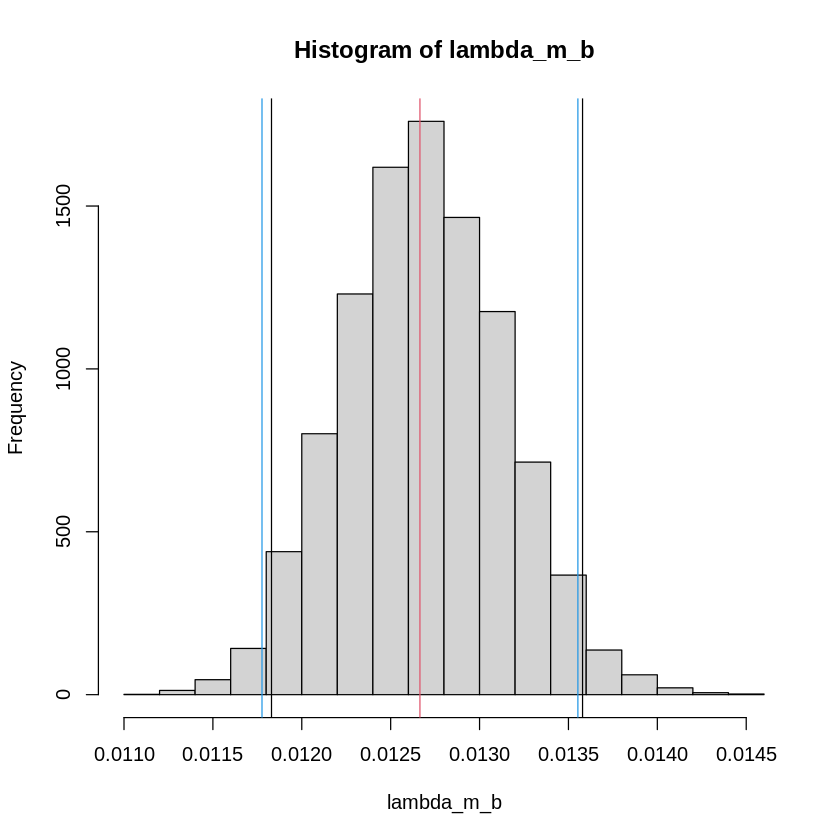

In [ ]:
#Graficamos la distribucion y los intervalos para comparar
hist(alpha_m_b)
abline(v = mom_gamma[1], col = 2)
abline(v = IC_alpha_mom_a)# IC asintotico
abline(v = (IC_alpha_mom), col = 4) # IC t-student
hist(lambda_m_b)
abline(v = mom_gamma[2], col = 2)
abline(v = IC_lambda_mom_a) # IC asintotico
abline(v = (IC_lambda_mom), col = 4) # IC t-student

boot(data, statistic, R, sim = "ordinary", stype = c("i", "f", "w"), 
     strata = rep(1,n), L = NULL, m = 0, weights = NULL, 
     ran.gen = function(d, p) d, mle = NULL, simple = FALSE, ...,
     parallel = c("no", "multicore", "snow"),
     ncpus = getOption("boot.ncpus", 1L), cl = NULL)


In [ ]:
library('boot')

In [ ]:
boot(datos, momentos_gamma, 1e4, sim = 'parametric')
#El comando 'parametric' indica que la distribución es conocida, pero no sus parámetros.


PARAMETRIC BOOTSTRAP


Call:
boot(data = datos, statistic = momentos_gamma, R = 10000, sim = "parametric")


Bootstrap Statistics :
      original  bias    std. error
t1* 1.01235221       0           0
t2* 0.01266466       0           0

Los estimadores calculados mediante simulación y con el paquete 'boot' son iguales

Mediana de una distribución: la distibución de la mediana generada por bootstrap tiene una media distinta y la varianza es mayor.

In [ ]:
x = rexp(50)
boot = replicate(1e4, median(sample(x, replace = TRUE)))
mean(boot)
sd(boot)

sim = replicate(1e4, median(rexp(1e3)))

mean(sim)
sd(sim)

[1] 0.5708663

[1] 0.1113491

[1] 0.6938414

[1] 0.03161647

# Clase 9 - Test de hipótesis

Realice un test de hipótesis asintótico de nivel 95% para la media de una población normal. Explicite la hipótesis alternativa.

Mediante simulación, 

1. Calcule la **cobertura empírica**. Es decir, realice el test para 10000 muestras y calcule la tasa de error de tipo 1.
2. Calcule la potencia del test para una grilla de hipótesis alternativas. Grafique la función de potencia. Observe qué pasa con la potencia cuando aumenta el tamaño de muestra y con la distanta de entre las hipótesis.
3. Aproxime la distribución muestral del p-valor tanto bajo $H_0$ como bajo $H_1$. ¿Cómo son las distribuciones? Qué pasa si aumentamos el tamaño de muestra? ¿y con la distancia entre hipótesis?

Repita los incisos anteriores con una distribución t de pocos grados de libertad y con una distribución exponencial. Recuerda que si $X\sim \mathcal{E}(\lambda)$ entonces $\overline{X}_n$ estima $1/\lambda$.






Test de hipótesis para la media poblacional:

$H_{0} : \mu = \mu_{0}$  Satus quo

$H_{1} : \mu \neq \mu_{0}$  Alternativa

Rechazo $H_{0}$ si: 

$\mid \overline{X} - \mu_{0} / (\sigma/ \sqrt{n} )\mid \geq Z_{1-\alpha/2}$



In [ ]:
test_n = function(muestra,alpha, mu_0){
  mu = mean(muestra)
  n=length(muestra)
  t = qt((1-alpha/2), (n-1))
  estadistico = (mu-mu_0)/(sd(muestra)/sqrt(n))
  decision_t = abs(estadistico) > t
  #True significa que rechazamos H0
  pvalor = 2*(pt(abs(estadistico), n-1, lower.tail = FALSE ))
  return(list(decision_t, pvalor))
}
#La hipotesis alternativa es que la media de la muestra es disitnto al valor con el que testeamos

In [ ]:
n = 100
mu = 0
ds = 1
alpha = 0.05
muestra = rnorm(n, mu, ds)
test_n(muestra, alpha, mu)

[[1]]
[1] FALSE

[[2]]
[1] 0.3291907

Cobertura empírica del test - Error de tipo 1

In [ ]:
n = 100
mu = 0
ds = 1
alpha = 0.05
error1 = c()
for (i in 1:1e4){
  muestra = rnorm(n, mu, ds)
  error1 = append(error1, test_n(muestra, alpha, mu)[1][[1]])
}

mean(error1)

[1] 0.0481

Un p-valor grande no es evidencia suficiente en favor de $H_{0}$, puede ocurrir que el test tenga baja potencia. Se define la potencia de un test como la probabilidad de rechazar $H_{0}$ cuando es falsa.

Podemos calcular la potencia de un test para la media de una población con la siguiente funcion:


$$\pi(\mu)= 1 - \Phi \left(\frac{\mu-\mu_{0}}{\frac{\sigma}{\sqrt{n}}}+Z_{1-\alpha/2}\right) + \Phi \left(\frac{\mu-\mu_{0}}{\frac{\sigma}{\sqrt{n}}}-Z_{1-\alpha/2}\right)$$

In [ ]:
##calculamos la potencia para un test con varinza conocida y mu_0 = 0
potencia = function(mu,n){
  mu_0 = 0
  sigma = 2
  alpha = 0.1
  ret1 = mu_0-mu
  ret2 = sigma/sqrt(n)
  ret3 = qnorm((1-alpha/2), mu , sigma)
  return(1-pnorm(ret1/ret2+ret3, mu, sigma)+pnorm(ret1/ret2-ret3, mu, sigma))
}

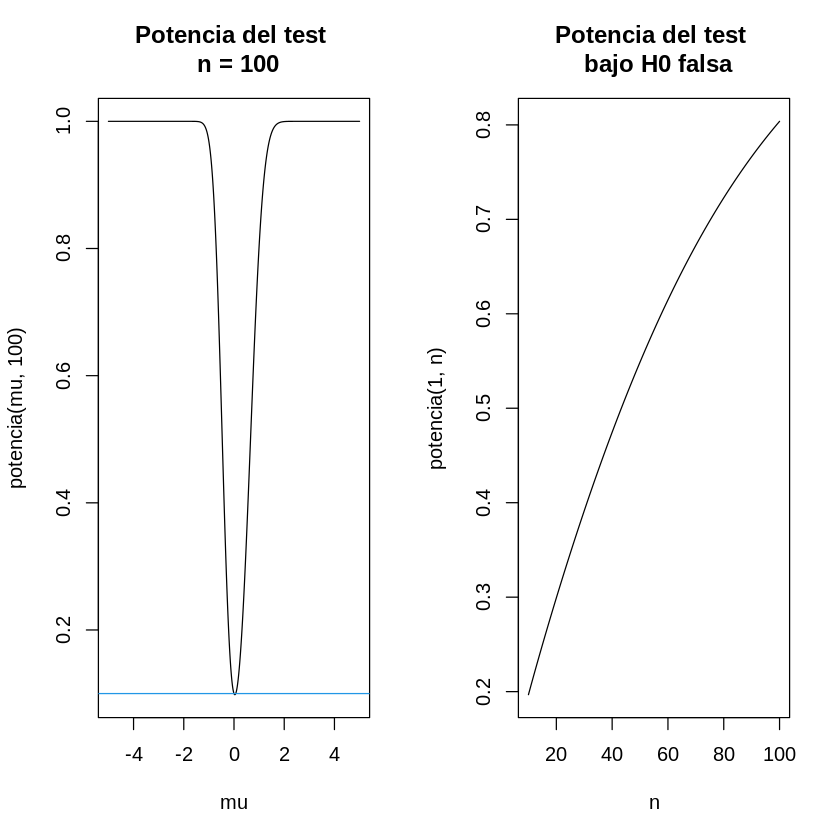

In [ ]:
mu = seq(-5,5,0.001)
n = seq(10,100)
par(mfrow = c(1, 2))

plot(mu,potencia(mu, 100), type = 'l', main = 'Potencia del test \n n = 100')
abline(h=0.1, col = 4)
plot(n,potencia(1, n), type = 'l', main = 'Potencia del test \n bajo H0 falsa')

El valor mínimo de la potencia es el valor de significación del test.

La potencia del test aumenta cuando $\mid\mu_{0}-\mu\mid $ aumenta

La potencia del test aumenta cuando $n $ aumenta

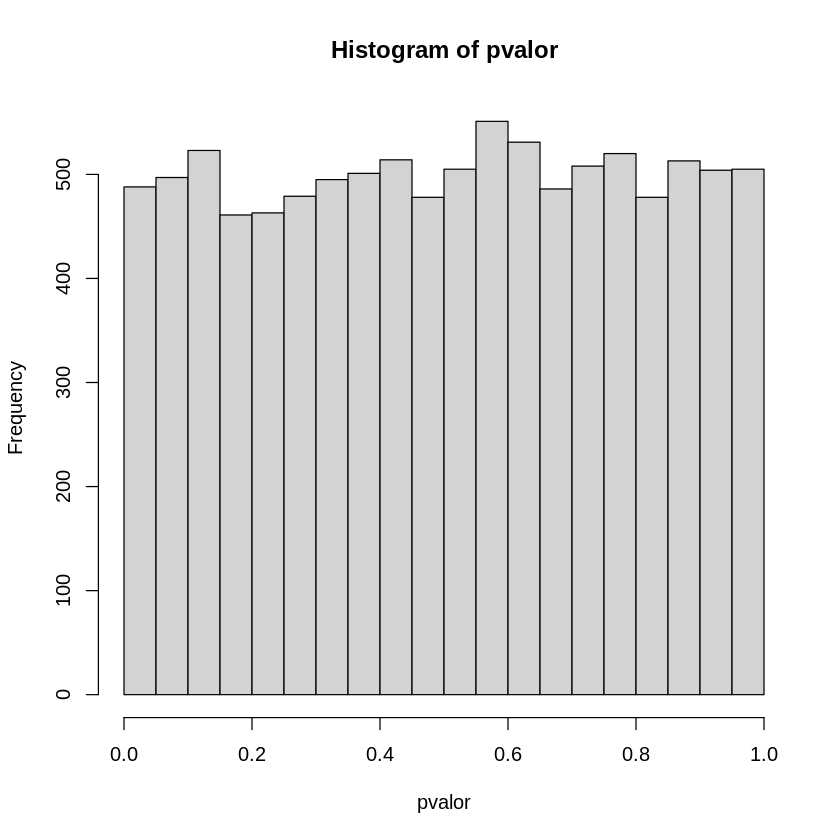

In [ ]:
#Distribución muestral del pvalor bajo H0 cierta
n = 100
mu = 0
ds = 1
alpha = 0.05
pvalor = c()
for (i in 1:1e4){
  muestra = rnorm(n, mu, ds)
  pvalor = append(pvalor, test_n(muestra, alpha, mu)[2][[1]])
}

hist(pvalor)

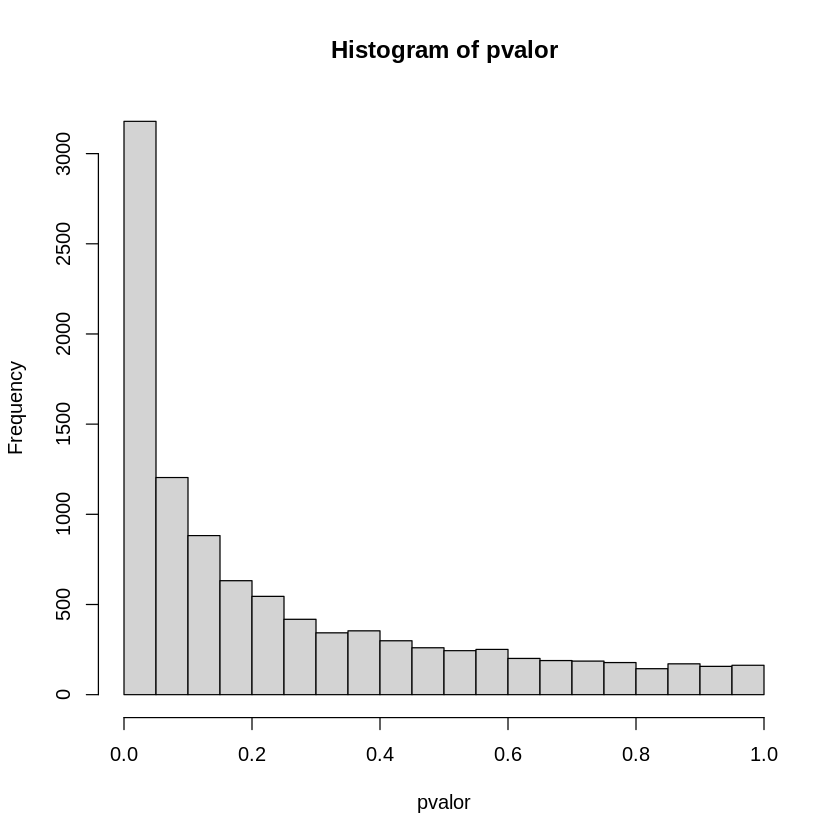

In [ ]:
#Distribución muestral del pvalor bajo H1 cierta
n = 100
mu = 0
ds = 1
alpha = 0.05
pvalor = c()
for (i in 1:1e4){
  muestra = rnorm(n, mu, ds)
  pvalor = append(pvalor, test_n(muestra, alpha, 0.15)[2][[1]])
}

hist(pvalor)

La distribución muestral del p-valor es uniforme cuando $H_{0}$ es cierta, y a medida que aumenta la distancia entre $H_{0}$ y la media verdadera la distribución se va acumulando en el valor cero. Aumentar el tamaño de muestra genera el mismo efecto que aumentar la distancia entre las hiotesis.

# Clase 10 - Test de permutaciones

Para el conjunto de datos `chickData.csv`:
* programe el test de permutaciones para testear la diferencia absoluta de medias y de medianas.
* compare con el test _t_ para muestras independientes con varianza distintas.

`

In [ ]:
d = read.table(file = 'ChickData.csv', header= T, sep = ',')

In [ ]:
d$feed = as.factor(d$feed)

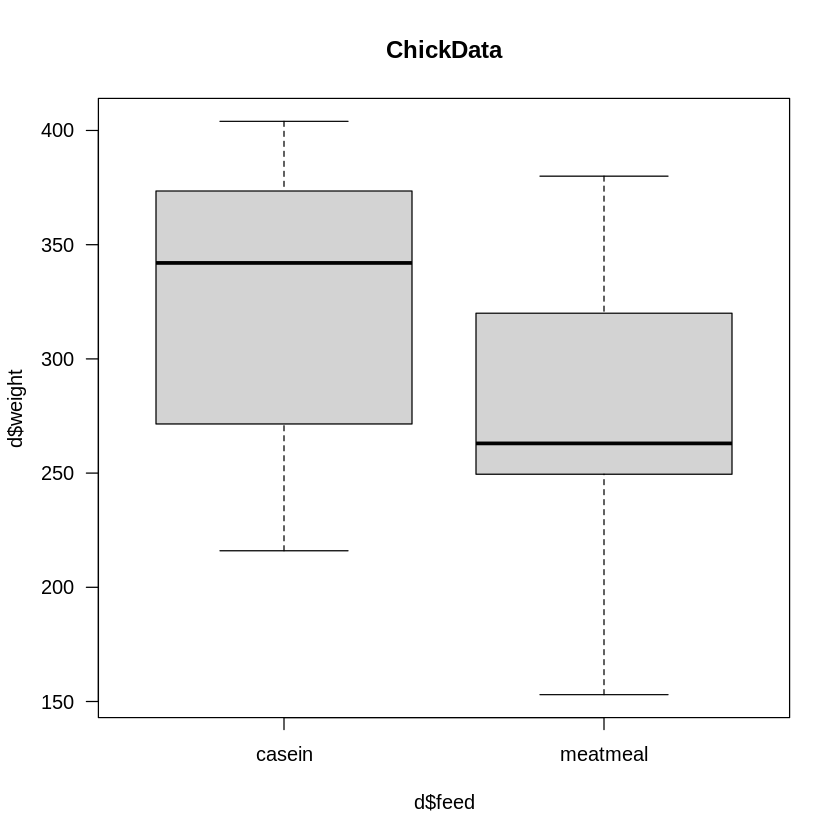

In [ ]:
boxplot(d$weight~d$feed, las=1, main = 'ChickData')

Test de permutaciones para tamaños de muestra chicos

In [ ]:
dif = function(d){
  x_mean = mean(d$weight[d$feed == 'casein'])
  y_mean = mean(d$weight[d$feed == 'meatmeal'])
  dif = abs( x_mean - y_mean)
  return (dif)
}
t = dif(d)#diferencia absoluta de medias en la muestra original
t

[1] 46.67424

In [ ]:
p = c()
for (i in 1:1e4){
      X = sample(d$weight) #permutamos los valores de weight
      DF = cbind(X, d$feed)
      colnames(DF) = c('weight', 'feed')
      DF = as.data.frame(DF)
      DF$feed = as.factor(d$feed)
      m = dif(DF)> t #testeamos cuantas veces la diferencia de medias es mayor a la muestra original
      p = cbind(p, m)
}

In [ ]:
mean(p) #Calculamos el p-valor

[1] 0.0977

T-test: Muestras independientes y varianza distinta

In [ ]:
t.test(x,y, paired = F, var.equal = F, alternative = c('two.sided'))


	Welch Two Sample t-test

data:  x and y
t = 1.7288, df = 20.799, p-value = 0.09866
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  -9.504377 102.852861
sample estimates:
mean of x mean of y 
 323.5833  276.9091 


Si consideramos $\alpha = 0.05$ como nivel de significación, podemos decir que no existe evidencia estadı́sticamente significativa para rechazar la hipótesis nula de que no hay diferencia entre las medias, sin embargo con $\alpha = 0.10$ sí podemos rechazar la hipótesis nula.
El p-valor arrojado por el test programado es 0.097 y el p-valor del ttest es 0.098, en este caso no influye esa diferencia en la decision a tomar.



# Clase 11a - Comparaciones múltiples (Bonferroni)

1. Genere una muestra $\mathcal{N}(0,1)$ y realice un test _t_ bilateral para $\mu=0$. Repeta 10000 veces y calcule la proporci\'on de rechazos.
2. Genere cinco muestras $\mathcal{N}(0,1)$ y testee que todas las medias sean $0$. Repita 10000 veces y calcule la proporci\'on de que haya al menos un rechazo.
3. Recalcule la proporci\'on de al menos un rechazo luego de aplicar la correcci\'on de Bonferroni.
4. Genere muestras con la alternativa y vea qu\'e pasa con la potencia. Conviene jugar con el valor de la alternativa y el tamaño de muestra hasta encontrar algún efecto.

In [ ]:
n = 100

p_valor=c()
for (i in 1:1e4){
 r = rnorm(n,0,1)
 p = t.test(r, mu = 0, paired = F, var.equal = F, alternative = c('two.sided'), conf.level = 0.95)
 p_valor = append(p_valor, p$p.value)
}
mean(p_valor<0.05)#probabilidad de rechazar una hipótesis nula erroneamente

[1] 0.0515

In [ ]:
n = 100

prop = c()
for (i in 1:1e4){
 r = replicate(5, rnorm(n, 0 ,1))
 p = apply(r, 2, t.test, alternative = c("two.sided"),mu = 0, paired = FALSE,
     var.equal = FALSE,conf.level = 0.95) 
 p_valor = c(p[[1]]$p.value, p[[2]]$p.value, p[[3]]$p.value, p[[4]]$p.value, p[[5]]$p.value)
 prop = append(prop, any(p_valor<0.05))#almenos un rechazo de las 5 muestras
}
mean(prop)#probabilidad de rechazar una hipótesis nula erroneamente

[1] 0.2292

In [ ]:
n = 100

prop_a = vector()
prop = vector()
for (i in 1:1e4){
 r = replicate(5, rnorm(n, 0 ,1))
 p = apply(r, 2, t.test, alternative = c("two.sided"),mu = 0, paired = FALSE,
     var.equal = FALSE,conf.level = 0.95) 

 p_v = c(p[[1]]$p.value, p[[2]]$p.value, p[[3]]$p.value, p[[4]]$p.value, p[[5]]$p.value)
 
 p_v_adj = p.adjust(p_v, method = 'bonferroni')#ajustamos los p-valor con el metodo de bonferroni

 prop = append(prop, any(p_v<0.05))
 prop_a = append(prop_a, any(p_v_adj <0.05))
}
mean(prop)
mean(prop_a)

[1] 0.2244

[1] 0.0495

Con el ajuste de bonferroni la proporción de rechazos es igual al nivel de significación del test.

In [ ]:
n = 100

prop_a = vector()
prop = vector()
for (i in 1:1e4){
 r1 = replicate(3, rnorm(n, 0 ,1))
 r2 = replicate(2, rnorm(n, 0.1 ,1))
 r = cbind(r1,r2)
 p = apply(r, 2, t.test, alternative = c("two.sided"),mu = 0, paired = FALSE,
     var.equal = FALSE,conf.level = 0.95) 

 p_v = c(p[[1]]$p.value, p[[2]]$p.value, p[[3]]$p.value,
           p[[4]]$p.value, p[[5]]$p.value)
 
 p_v_adj = p.adjust(p_v, method = 'bonferroni')#ajustamos los p-valor con el metodo de bonferroni

 prop = append(prop, any(p_v<0.05))
 prop_a = append(prop_a, any(p_v_adj <0.05))
}
mean(prop)
mean(prop_a)

[1] 0.402

[1] 0.1303

Generamos 2 de las 5 muestras con hipótesis nula falsas, en este caso la correción de bonferroni nos puede conducir a obtener más falsos negativos, al agrandar los p-valor de cada test. Aumenta el error de tipo 2 y disminuye la potencia del test.

# Clase 11 - Comparaciones múltiples (Benjamini-Hochberg)

Testeamos $m=140$ variables para dos familias normales. Con las siguientes
medias verdaderas:
```
nx <- 50
ny <- 50
m0 <- 120
m1 <- 20
mu.x <- rep(0, m0 + m1)
mu.y <- c(rep(0, m0), seq(0.3, 0.6, length = m1))
```
Hacemos $m=140$ tests _t_ bilaterales para dos muestras normales independientes con tamaño muestral $n=50$.

2. Calcule la proporción de $H_0$ rechazadas erróneamente y correctamente (potencia).
3. Calcule el _false discovery rate_.
4.Aplique Bonferroni y BH y recalcule (use el comando p.adjust}. 

¿Cómo se comparan las tres cantidades para Bonferroni, BH y el caso sin corregir?
    

In [ ]:
m = 140
nx = 50 
ny = 50
m0 = 120
m1 = 20
mu.x = rep(0, m0+m1)
mu.y = c(rep(0, m0), seq(0.3, 0.6, length=m1))

In [ ]:
x = vector()
y = vector()
for (i  in 1:50){
  x = rbind(x, rnorm(140,0,1) )
  yy = mu.y + rnorm(140,0,1)
  y = rbind(y, yy )
}

In [ ]:
p_valor = vector()
for (i in 1:140){
  test = t.test(x[,i],y[,i], mu = 0, paired = F, var.equal = F,
         alternative = c('two.sided'), conf.level = 0.95)
  p_valor = append (p_valor, test$p.value)

}

  p_bon = p.adjust(p_valor, method = 'bonferroni')
  p_bh = p.adjust(p_valor, method = 'BH')



In [ ]:
#Calculamos la tasa de error (veces que la decision es incorrecta)
error = append(p_valor[1:120]<0.05 , p_valor[121:140]>0.05)
error_bon = append(p_bon[1:120]<0.05, p_bon[121:140]>0.05)
error_bh = append(p_bh[1:120]<0.05, p_bh[121:140]>0.05)

mean(error)
mean(error_bon)
mean(error_bh)

[1] 0.1142857

[1] 0.1285714

[1] 0.1071429

In [ ]:
#Rechazos correctos - Potencia del test
  mean(p_valor[121:140]<0.05)
  mean(p_bon[121:140]<0.05)
  mean(p_bh[121:140]<0.05)

[1] 1

[1] 0.8

[1] 0.85

In [ ]:
#Probabilidad de cometer al menos un error de tipo 1:
#P(al menos 1 error) = 1-P(ningun error de tipo 1)
p_error1 = function(alfa, m){
  return(1-(1-alfa)^m)
}

m = 140
alfa = 0.05
alfa_bon = alfa/m

p_error1(alfa, m) #Sin el ajuste
p_error1(alfa_bon, m) # con el ajuste de Bonferroni

[1] 0.9992391

[1] 0.04877907

In [ ]:
#Rechazos erróneos
mean(p_valor[1:120]<0.05)
mean(p_bon[1:120]<0.05)
mean(p_bh[1:120]<0.05)

[1] 0.04166667

[1] 0

[1] 0

Primero analizamos analíticamente y vemos que sin la corrección, la probabilidad de incurrir en falsos descubrimientos es muy cercana a 1, y con la corrección esta probabilidad cae a casi 5%. Luego en la comprobación vemos que con la correción no hubo falsos descubrimientos, mientras que sin la correción el 4,1% de las veces se incurrió en rechazos erróneos.
Podemos concluir que la correción de bonferroni disminuye la potencia del test, pero a la vez disminuye la probabilidad de falsos descubrimientos, or lo tanto se pierde por un lado pero se gana por el otro.

##Ejercicios a eleccion

Los ejercicios van adjuntos en un html.